# Spatial Weights

In [1]:
from IPython.display import HTML

%matplotlib inline

import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz.splot.esda import plot_moran, plot_local_autocorrelation, lisa_cluster
import contextily as ctx
import matplotlib.pyplot as plt

db = gpd.read_file('../data/bh.gpkg')

/opt/conda/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Spatial weights

### Lattice example

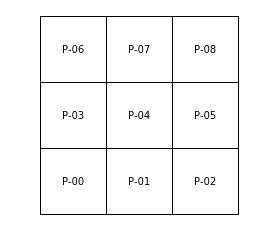

In [2]:
import numpy as np
from shapely.geometry import Polygon

# do a regular 3x3 lattice and draw it here
w = weights.lat2W(3, 3, rook=True)
# Get points in a grid
l = np.arange(3)
xs, ys = np.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    polys.append(poly)
# Convert to GeoSeries
polys = gpd.GeoSeries(polys)
gdf = gpd.GeoDataFrame({'geometry': polys, 
                        'id': ['P-%s'%str(i).zfill(2) for i in range(len(polys))]})
w.remap_ids(gdf['id'].values)
# Annotate & Visualise
ax = polys.plot(edgecolor='k', facecolor='w')
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x for p in polys],
         [p.centroid.y for p in polys],
         [i for i in gdf['id']])]
ax.set_axis_off()

* Full matrix

In [3]:
pd.DataFrame(w.full()[0], 
             index=gdf['id'],
             columns=gdf['id'],
            ).astype(int)

id,P-00,P-01,P-02,P-03,P-04,P-05,P-06,P-07,P-08
id,,,,,,,,,
P-00,0,1,0,1,0,0,0,0,0
P-01,1,0,1,0,1,0,0,0,0
P-02,0,1,0,0,0,1,0,0,0
P-03,1,0,0,0,1,0,1,0,0
P-04,0,1,0,1,0,1,0,1,0
P-05,0,0,1,0,1,0,0,0,1
P-06,0,0,0,1,0,0,0,1,0
P-07,0,0,0,0,1,0,1,0,1
P-08,0,0,0,0,0,1,0,1,0


### Real-word data

In [4]:
w_queen = weights.Queen.from_dataframe(db)

In [5]:
w_k1 = weights.KNN.from_dataframe(db, k=1)

/opt/conda/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 26 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


* Visualising weights

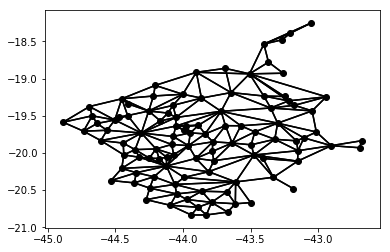

In [6]:
w_queen.plot(db);

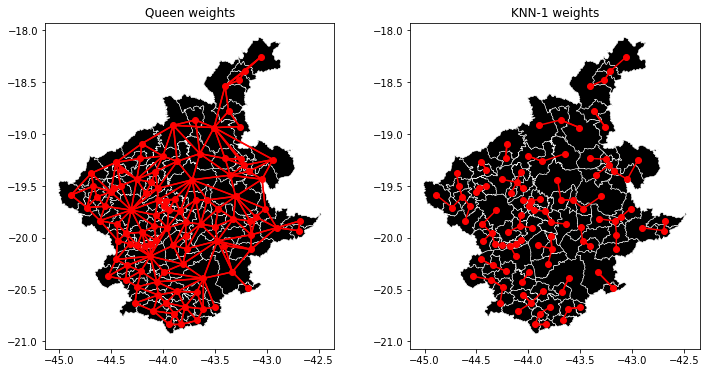

In [7]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

db.plot(color='k', ax=axs[0], 
        edgecolor='w', linewidth=0.5)
w_queen.plot(db, ax=axs[0], color='red')
axs[0].set_title('Queen weights')

db.plot(color='k', ax=axs[1], 
        edgecolor='w', linewidth=0.5)
w_k1.plot(db, ax=axs[1], color='red')
axs[1].set_title('KNN-1 weights')

plt.show()

* And fancier graphs are also possible...

In [8]:
blob = """
       <blockquote class="twitter-tweet" data-lang="en">
       <p lang="en" dir="ltr">
           A few more mesmerizing bundled graphs from Spatial Weights Matrices and the 
           <a href="https://twitter.com/hashtag/PySAL?src=hash&amp;ref_src=twsrc%5Etfw">
           #PySAL</a>/<a href="https://twitter.com/datashader?ref_src=twsrc%5Etfw">@datashader</a>
           code I used. Tbh, I&#39;m not sure bundles are more useful at identifying the 
           spatial structure than traditional graphs, what do people think? 
           <a href="https://t.co/UkaPZlvUqL">https://t.co/UkaPZlvUqL</a> 
           <a href="https://t.co/3QW7z0IaCB">pic.twitter.com/3QW7z0IaCB</a></p>&mdash; 
           Dani Arribas-Bel (@darribas) 
           <a href="https://twitter.com/darribas/status/1056293955422294016?ref_src=twsrc%5Etfw">
           October 27, 2018</a></blockquote>
        <script async src="https://platform.twitter.com/widgets.js" 
        charset="utf-8"></script>
       """
HTML(blob)

**CHALLENGE** - Create a spatial weights matrix using the KNN algorithm and picking the average number of neighbors under the queen criterium (hint: checkout the `mean_neighbors` attribute in `w_queen`)

# *Explore* spatial data

## Global Spatial autocorrelation

In [9]:
blurb = ('<a href="https://mybinder.org/v2/gh/darribas/int_sp_auto/master">'\
         '<img src="https://mybinder.org/badge_logo.svg" alt="Binder" /></a>')
HTML(blurb)

* Shuffle values across space

In [10]:
np.random.seed(1234)
db['Random Industry Diversity'] = db['Industry Diversity'].sample(frac=1).values

* Same values, different geographical implications...

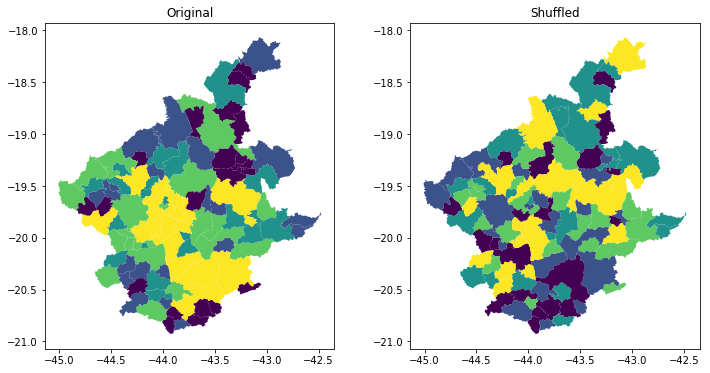

In [11]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
db.plot(column='Industry Diversity', scheme='quantiles', ax=axs[0])
axs[0].set_title('Original')
db.plot(column='Random Industry Diversity', scheme='quantiles', ax=axs[1])
axs[1].set_title('Shuffled')
plt.show()

* Moran's I

In [12]:
moran = esda.Moran(db['Industry Diversity'], w_queen)

In [13]:
moran.I

0.3284250081195203

In [14]:
moran.p_sim

0.001

---

In [15]:
moran_shuffled = esda.Moran(db['Random Industry Diversity'], w_queen)

In [16]:
moran_shuffled.I

-0.02618004673208319

In [17]:
moran_shuffled.p_sim

0.4

* Moran Scatterplots

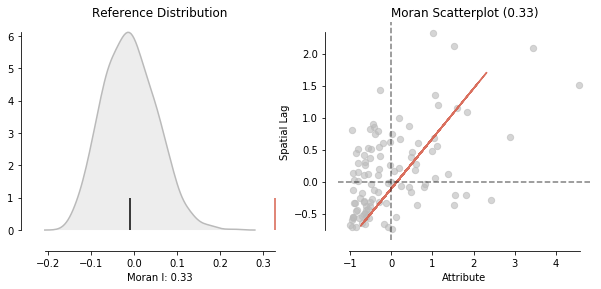

In [18]:
plot_moran(moran);

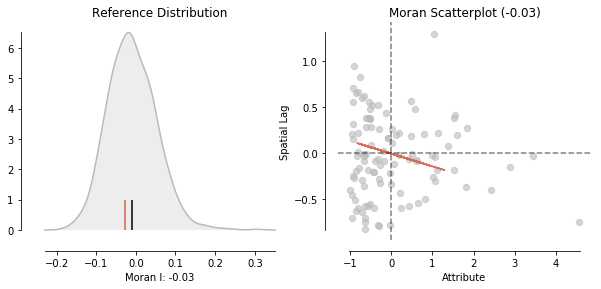

In [19]:
plot_moran(moran_shuffled);

**CHALLENGE** - Compute Moran's I for the Average Monthly Wage and explore its scatterplot

## Local Spatial autocorrelation

In [20]:
lisa = esda.Moran_Local(db['Industry Diversity'], w_queen)

/opt/conda/lib/python3.7/site-packages/pysal/explore/esda/moran.py:895: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


* Overall plot

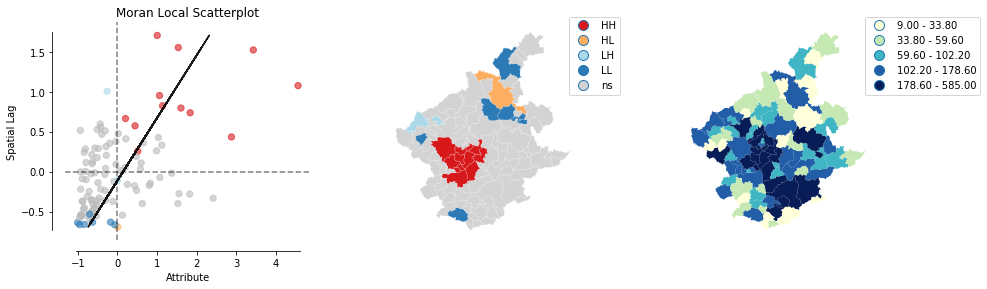

In [21]:
plot_local_autocorrelation(lisa, db, 'Industry Diversity');

* Cluster map

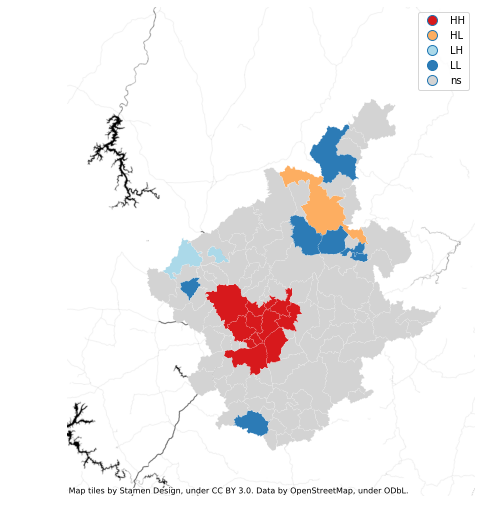

In [23]:
f, ax = plt.subplots(1, figsize=(9, 9))
lisa_cluster(lisa, db.to_crs(epsg=3857), ax=ax)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND)
plt.show()

**CHALLENGE** 

- Create a similar LISA map for average monthly job
- [If you have time] Calculate job density and replicate the global and local analysis

---


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science with Python - UFMG'19</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/darribas/gds_ufmg19" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.
